In [1]:
key = '' #google api key
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps

In [2]:
def plotMap(polyGrid, locations=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        sLoc.append((v[0][0],v[0][1]))
        sHtext.append(str(k))
    
    if len(locations)!=0:
        sLoc = locations
        sHtext = list(map(lambda x:str(x), locations))
        
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

243


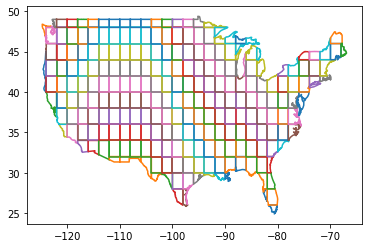

In [3]:
usaPolyGrid = pickle.load(open("usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

1215

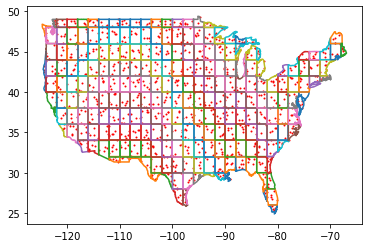

In [5]:
# %matplotlib auto
# %matplotlib inline
locs = []
for grid,coor in usaPolyGrid.items():
    poly = Polygon(np.flip(coor))
    x,y = poly.exterior.xy
    plt.plot(x,y)
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    while count<5:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(pnt):
            plt.scatter([pnt.x],[pnt.y],c='r',s=1)
            locs.append((pnt.y,pnt.x))
            count += 1
len(locs)

In [6]:
plotMap(usaPolyGrid, locations=locs)

Figure(layout=FigureLayout(height='420px'))

In [7]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
for grid,coor in usaPolyGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if str(grid) not in os.listdir("data"):
        saveFolder = 'data/{}'.format(grid)
        os.mkdir(saveFolder)
        print("Searching new grid {}".format(grid))
        while count<5 and trials<5:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    print("Valid location found: {}".format(location))
                    locList.append(location)
                    saveFile = saveFolder + "/{}".format(location)
                    if os.path.exists(saveFile)==False:
                        os.mkdir(saveFile)

                    for heading in [0,90,180]:
                        imgUrl = base + ext.format(location, heading, 10000, key)
                        urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                    count += 1
                    trials = 0
                else:
                    print("Failed trial")
        i = input("Completed grid {}:".format(grid))
        if i=='0':
            break
    else:
        print("Grid {} already has data".format(grid))

Searching new grid 0
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Failed trial
Trial: 3, count: 0
Failed trial
Trial: 4, count: 0
Failed trial
Trial: 5, count: 0
Failed trial


KeyboardInterrupt: 

In [8]:
location = '46.514382,10.013988'
heading = 360
radius = 10000
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'.format(location,
                                                                                      heading,
                                                                                      radius,
                                                                                      key)
imgUrl = base + ext
metaUrl = base + '/metadata' + ext
requests.get(metaUrl).json()

{'error_message': 'This functionality is only available if an API key or a client ID is provided: /metadata',
 'status': 'REQUEST_DENIED'}